In [1]:
%load_ext autoreload
%autoreload 2

# 2D Navier Stokes lid-driven flow

Benchmark on the 2D Navier Stokes lid-driven flow as proposed in the PINNACLE benchmark paper (https://arxiv.org/pdf/2306.08827) (see Appendix B11: (**NS2d-C**)).

We dig through the PINNACLE code database to retrieve the experimental setting (number of collocation points, number of iterations, ...) as well as the reference values of the solution.

In [2]:
import numpy as np

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 8192 // 10
DEFAULT_NUM_BOUNDARY_POINTS = 2048 // 10

ref_data = np.loadtxt("lid_driven_a4.dat", comments="%").astype(np.float32)

## DeepXDE


We use the JAX backend.

In [3]:
seed = 1

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.

2024-11-26 17:26:09.069735: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Compiling model...
'compile' took 1.115234 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.22e-02, 4.19e-03, 1.79e-01, 1.35e+00, 1.11e-02, 1.14e-01, 6.14e-03, 0.00e+00]    [3.22e-02, 4.19e-03, 1.79e-01, 1.35e+00, 1.11e-02, 1.14e-01, 6.14e-03, 0.00e+00]    []  
1000      [5.48e-03, 4.06e-03, 1.70e-03, 1.58e-02, 6.91e-03, 2.49e-03, 1.29e-03, 1.26e-06]    [5.48e-03, 4.06e-03, 1.70e-03, 1.58e-02, 6.91e-03, 2.49e-03, 1.29e-03, 1.26e-06]    []  
2000      [2.98e-03, 2.62e-03, 3.80e-04, 2.18e-03, 5.98e-03, 5.66e-04, 1.01e-03, 2.76e-05]    [2.98e-03, 2.62e-03, 3.80e-04, 2.18e-03, 5.98e-03, 5.66e-04, 1.01e-03, 2.76e-05]    []  
3000      [1.75e-03, 8.74e-04, 2.28e-04, 2.85e-03, 6.18e-04, 1.12e-03, 5.93e-04, 4.66e-05]    [1.75e-03, 8.74e-04, 2.28e-04, 2.85e-03, 6.18e-04, 1.12e-03, 5.93e-04, 4.66e-05]    []  
4000      [5.

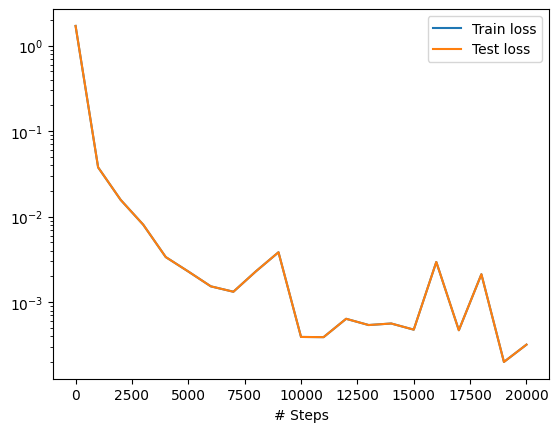

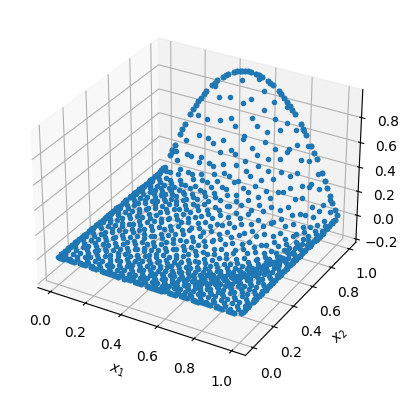

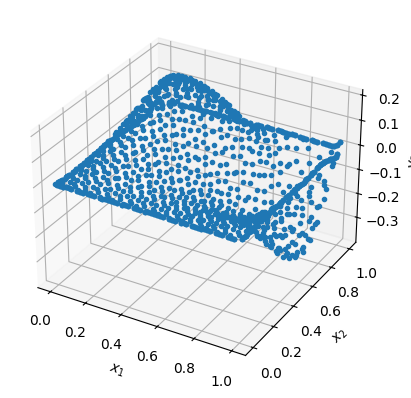

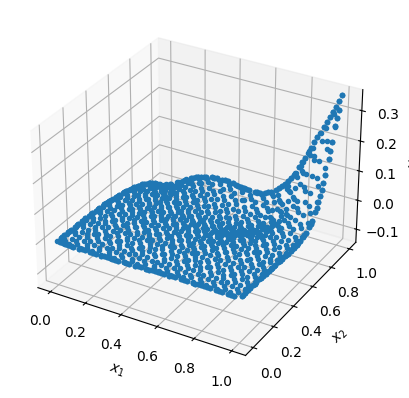

In [4]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)

nu = 1 / 100
a = 4

# PDE
def ns_pde(x, u):
    u_val, u_fn = u
    u_vel, v_vel, _ = u_val[:, 0:1], u_val[:, 1:2], u_val[:, 2:]
    u_vel_x, _ = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y, _ = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx, _ = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy, _ = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x, _ = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y, _ = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx, _ = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy, _ = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x, _ = dde.grad.jacobian(u, x, i=2, j=0)
    p_y, _ = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
    momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

bbox=[0, 1, 0, 1]
geom = dde.geometry.Rectangle(xmin=[bbox[0], bbox[2]], xmax=[bbox[1], bbox[3]])
def boundary_top(x, on_boundary):
    return on_boundary and np.isclose(x[1], bbox[3])

def boundary_not_top(x, on_boundary):
    return on_boundary and not np.isclose(x[1], bbox[3])
            
bc1 = dde.icbc.DirichletBC(geom, lambda x: a * x[:, 0:1] * (1 - x[:, 0:1]), boundary_top, 0)
bc2 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_top, 1)
bc3 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_not_top, 0)
bc4 = dde.icbc.DirichletBC(geom, lambda _: 0, boundary_not_top, 1)
bc5 = dde.icbc.PointSetBC(np.array([[0, 0]]), np.array([[0]]), 2)




data = dde.data.PDE(
    geom,
    ns_pde,
    [bc1, bc2, bc3, bc4, bc5],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    # train_distribution="uniform" # this is the default
    # num_test=None # this is the Default, we perform a evaluation callback on the same dataset as the training (see the test column in the training log)
)
net = dde.nn.FNN([2] + [100] * 5 + [3], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
# Not sure how to do this in JAX
# model.compile("L-BFGS")
# losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# X, y_true = gen_testdata()
# y_pred = model.predict(X)
# f = model.predict(X, operator=pde)
# print("Mean residual:", np.mean(np.absolute(f)))
# print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
# np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

## With Jinns

In [61]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [62]:
eqx_list = (
    (eqx.nn.Linear, 2, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 100),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 100, 3)
)
key, subkey = random.split(key)
u_pinn, init_nn_params_pinn = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2)

In [63]:
n = DEFAULT_NUM_DOMAIN_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/data/_DataGenerators.py:436: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.n = 819). Modifying self.n to self.n = 841.
  warnings.warn(


In [64]:
nu = 1 / 100
a = 4

In [65]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_nn_params_pinn,
    eq_params={
        "nu":nu
    }
)

In [66]:
from jinns.loss import PDEStatio

class NavierStokes2DStatio(PDEStatio):
    def equation(self, x, u_p, params):
        u_ = lambda x, params: u_p(x, params)[0:2]
        p_ = lambda x, params: u_p(x, params)[2]

        ux = lambda x, params: u_(x, params)[0]
        uy = lambda x, params: u_(x, params)[1]
    
        dux_dx = lambda x: grad(ux, 0)(x, params)[0]
        dux_dy = lambda x: grad(ux, 0)(x, params)[1]
    
        duy_dx = lambda x: grad(uy, 0)(x, params)[0]
        duy_dy = lambda x: grad(uy, 0)(x, params)[1]

        dp_dx = lambda x: grad(p_)(x, params)[0]
        dp_dy = lambda x: grad(p_)(x, params)[1]


        return jnp.array(
            [
                ux(x, params) * dux_dx(x) + uy(x, params) * dux_dy(x) + dp_dx(x)
                    - params.eq_params["nu"] * jinns.loss.laplacian_rev(x, lambda x, params: ux(x, params), params, eq_type="statio_PDE"),
                ux(x, params) * duy_dx(x) + uy(x, params) * duy_dy(x) + dp_dy(x)
                    - params.eq_params["nu"] * jinns.loss.laplacian_rev(x, lambda x, params: uy(x, params), params, eq_type="statio_PDE"),
                dux_dx(x) + duy_dy(x), # could have used jinns.loss.divergence_rev but we save computational resources here
            ]
        )

In [67]:
ns_loss = NavierStokes2DStatio()

loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1, observations=1, boundary_loss=1
)

omega_boundary_fun = {
    "xmin": lambda x: jnp.array([0.0, 0.0]),
    "xmax": lambda x: jnp.array([0.0, 0.0]),
    "ymin": lambda x: jnp.array([0.0, 0.0]),
    "ymax": lambda x: jnp.array([a * x[0] * (1 - x[0]), 0])
}
omega_boundary_condition = {
    "xmin": "dirichlet",
    "xmax": "dirichlet",
    "ymin": "dirichlet",
    "ymax": "dirichlet",
}
omega_boundary_dim = { # We have no boundary condition concerning p
    "xmin": jnp.s_[0:2],
    "xmax": jnp.s_[0:2],
    "ymin": jnp.s_[0:2],
    "ymax": jnp.s_[0:2],
}

In [68]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=jnp.array([[0, 0]]),
    observed_values=jnp.array([[0]])
)

In [69]:
loss_pinn = jinns.loss.LossPDEStatio(
    u=u_pinn,
    loss_weights=loss_weights,
    dynamic_loss=ns_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=omega_boundary_condition,
    omega_boundary_dim=omega_boundary_dim,
    params=init_params_pinn,
    obs_slice=jnp.s_[2:3]
)

In [70]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 20000

In [71]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True
)


Compilation took
 3.549642324447632 

[train] Iteration 0: loss value = 0.4826594889163971
[train] Iteration 1000: loss value = 0.019360477104783058
[train] Iteration 2000: loss value = 0.011370090767741203
[train] Iteration 3000: loss value = 0.007745510898530483
[train] Iteration 4000: loss value = 0.004800945520401001
[train] Iteration 5000: loss value = 0.002563578076660633
[train] Iteration 6000: loss value = 0.0015532525721937418
[train] Iteration 7000: loss value = 0.0008305836236104369
[train] Iteration 8000: loss value = 0.0009215076570399106
[train] Iteration 9000: loss value = 0.0005844017723575234
[train] Iteration 10000: loss value = 0.0006021473091095686
[train] Iteration 11000: loss value = 0.0006117343436926603
[train] Iteration 12000: loss value = 0.0005238930461928248
[train] Iteration 13000: loss value = 0.0005418793298304081
[train] Iteration 14000: loss value = 0.0004745504120364785
[train] Iteration 15000: loss value = 0.00017145913443528116
[train] Iteration 160

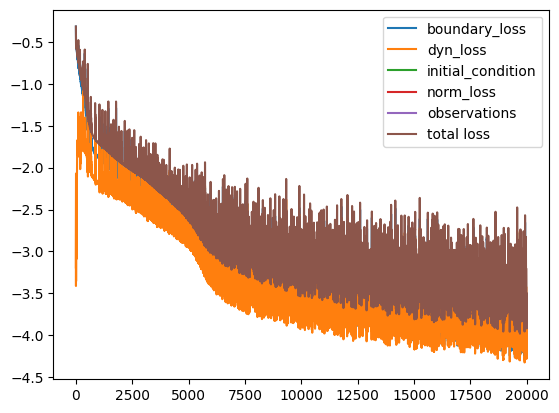

In [72]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

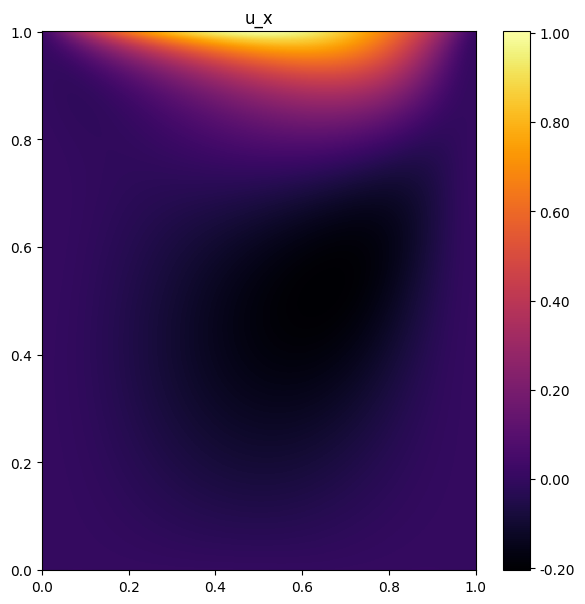

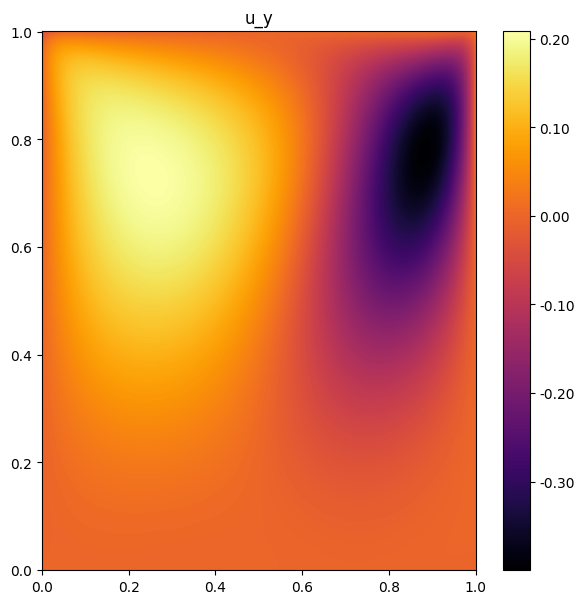

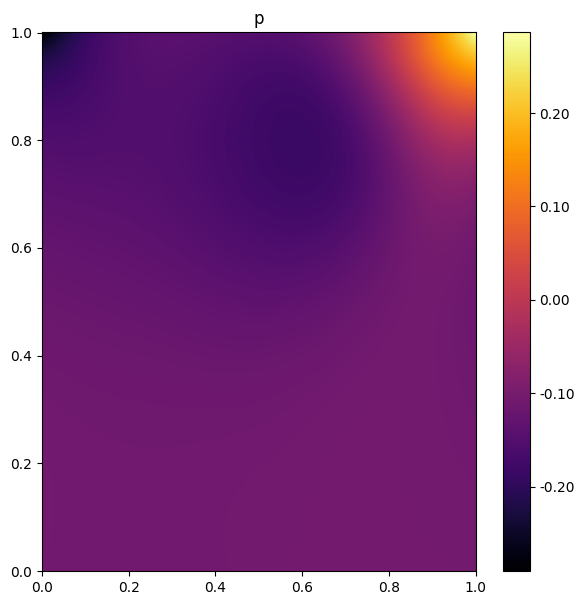

In [73]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_x = lambda x: u_pinn(x, params_pinn)[0]
jinns.plot.plot2d(
    fun=u_x,
    xy_data=val_xy_data,
    title="u_x"
)

u_y = lambda x: u_pinn(x, params_pinn)[1]
jinns.plot.plot2d(
    fun=u_y,
    xy_data=val_xy_data,
    title="u_y"
)

p = lambda x: u_pinn(x, params_pinn)[2]
jinns.plot.plot2d(
    fun=p,
    xy_data=val_xy_data,
    title="p"
)

## Comparisons

In [74]:
import sys
sys.path.append('../')

from PINNacle_utils import compute_relative_errors

nan_mask = np.isnan(ref_data).any(axis=1)
test_x = ref_data[~nan_mask, :2]
test_y = ref_data[~nan_mask, 2:]

(10201, 5)


In [75]:
compute_relative_errors(test_y, model.predict(test_x))

l1re=0.06400814, l2re=0.10512915


In [76]:
pred = jax.vmap(u_pinn, (0, None))(test_x, params_pinn)
# pred_ = jnp.copy(pred)
# pred_ = pred_.at[:, 0].set(pred[:, 1])
# pred_ = pred_.at[:, 1].set(pred[:, 0])
compute_relative_errors(test_y, pred)

l1re=0.5501547, l2re=0.9032236
